In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
#import src.visuals as vs
from matplotlib import pyplot as plt
#from IPython.display import display # Allows the use of display() for DataFrames
from scipy.stats import norm
# Import supplementary visualizations code visuals.py
#import lightgbm as lgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#from lightgbm.sklearn import LGBMClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,fbeta_score,make_scorer,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import pickle

from sklearn.externals import joblib
seed = 3

In [2]:
bc = pd.read_csv('data/branded_content_events.csv')
ai = pd.read_csv('data/app_install_events.csv')
ck = pd.read_csv('data/checkout_events.csv')

### data quality check

In [3]:
bc.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024077 entries, 0 to 2024076
Data columns (total 4 columns):
platform         2024077 non-null object
campaign_name    2024077 non-null object
event_time       2024077 non-null int64
uid              2024077 non-null object
dtypes: int64(1), object(3)
memory usage: 61.8+ MB


In [4]:
bc['uid'].nunique()

1690513

In [5]:
bc = bc.drop_duplicates()

In [6]:
bc.rename(columns={'event_time': 'ad_event_time'}, inplace=True)

In [7]:
bc.shape

(2023418, 4)

### EDA

In [8]:
bc['ad_event_time'] = pd.to_datetime(bc['ad_event_time'],unit='s')
bc['ad_event_date'] = bc['ad_event_time'].dt.date

In [9]:
bc.head()

,platform,campaign_name,ad_event_time,uid,ad_event_date
0,iPhone,author_88,2019-03-01 00:00:00,15a862,2019-03-01
1,iPhone,author_219,2019-03-01 00:00:01,0a9627,2019-03-01
2,iPhone,author_88,2019-03-01 00:00:02,073ae4,2019-03-01
3,iPhone,author_88,2019-03-01 00:00:04,12aff3,2019-03-01
4,iPhone,author_88,2019-03-01 00:00:04,1a0528,2019-03-01


In [10]:
bc['ad_dow'] = bc['ad_event_time'].dt.dayofweek

In [11]:
bc['ad_hour'] = bc['ad_event_time'].dt.hour

In [12]:
ad_cnt = bc.groupby('ad_event_date')['uid'].count().reset_index().sort_values(by='ad_event_date')

Text(0,0.5,'Number of ads')

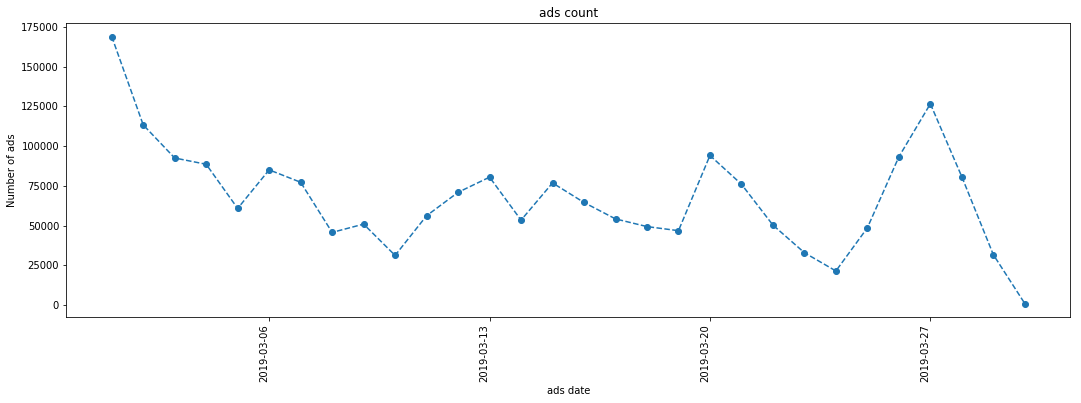

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(ad_cnt['ad_event_date'],ad_cnt['uid'],'o--')
ax.set_title('ads count')
ax.set_xlabel('ads date')
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Number of ads')

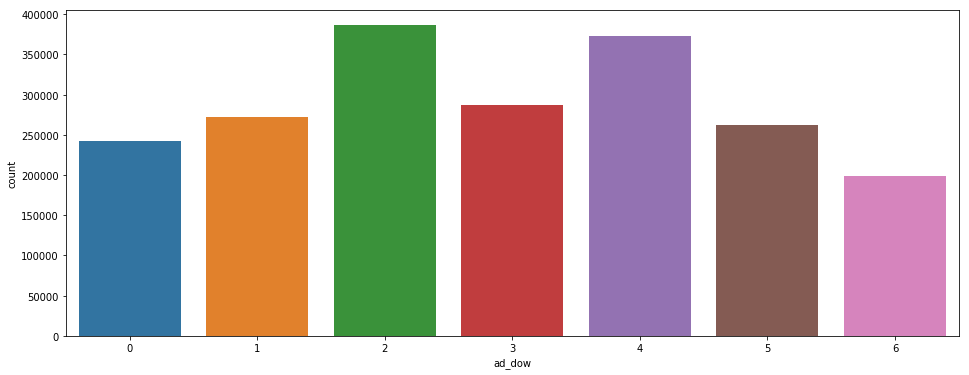

In [14]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="ad_dow", data=bc)

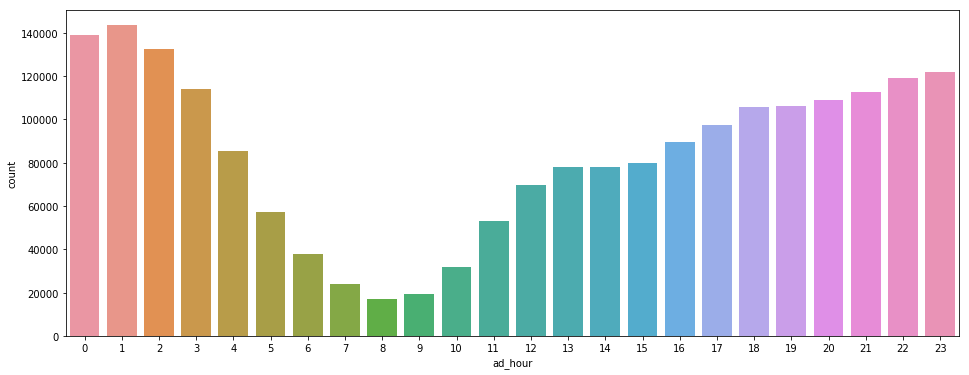

In [15]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="ad_hour", data=bc)

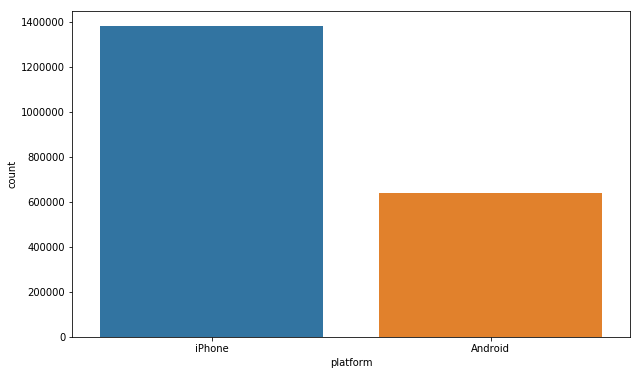

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="platform", data=bc)

In [17]:
top_ten_list = bc['campaign_name'].value_counts().nlargest(10).index.tolist()

In [18]:
bc['campaign_name_std'] = np.where(bc['campaign_name'].isin(top_ten_list),bc['campaign_name'],'non_top_ten')

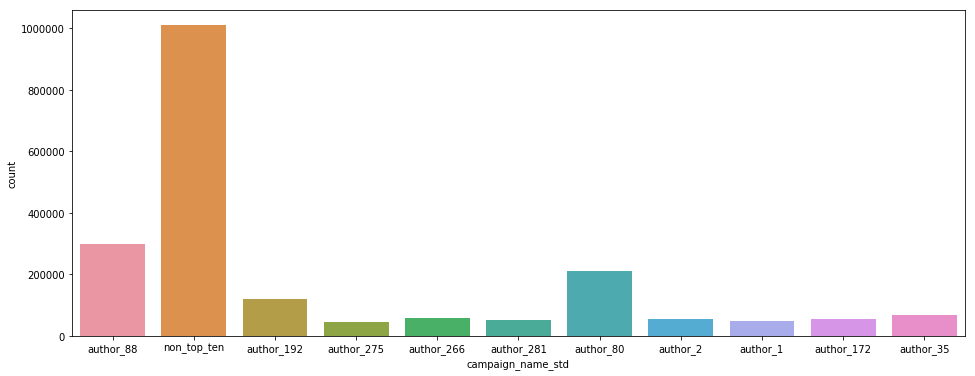

In [19]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="campaign_name_std", data=bc)

In [20]:
bc['campaign_name'].nunique()

281

In [21]:
### App Install

In [22]:
ai.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143149 entries, 0 to 143148
Data columns (total 5 columns):
uid           62213 non-null object
device_id     143149 non-null object
event_time    143149 non-null int64
article_id    62213 non-null float64
source        143149 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 5.5+ MB


In [23]:
ai = ai.drop_duplicates()

In [24]:
ai.rename(columns={'event_time': 'ai_event_time'}, inplace=True)

In [25]:
ai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143146 entries, 0 to 143148
Data columns (total 5 columns):
uid              62212 non-null object
device_id        143146 non-null object
ai_event_time    143146 non-null int64
article_id       62212 non-null float64
source           143146 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 6.6+ MB


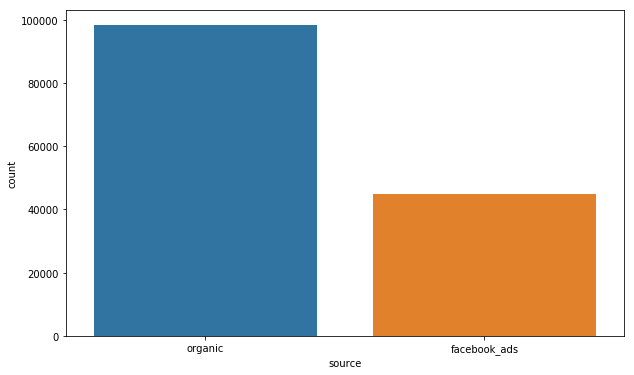

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="source", data=ai)

In [27]:
ai['ai_event_time'] = pd.to_datetime(ai['ai_event_time'],unit='s')
ai['ai_event_date'] = ai['ai_event_time'].dt.date
ai['ai_dow'] = ai['ai_event_time'].dt.dayofweek
ai['ai_hour'] = ai['ai_event_time'].dt.hour

In [28]:
ai_cnt = ai.groupby('ai_event_date').size().to_frame('ai_cnt').reset_index().sort_values(by='ai_event_date')

Text(0,0.5,'Number of ads')

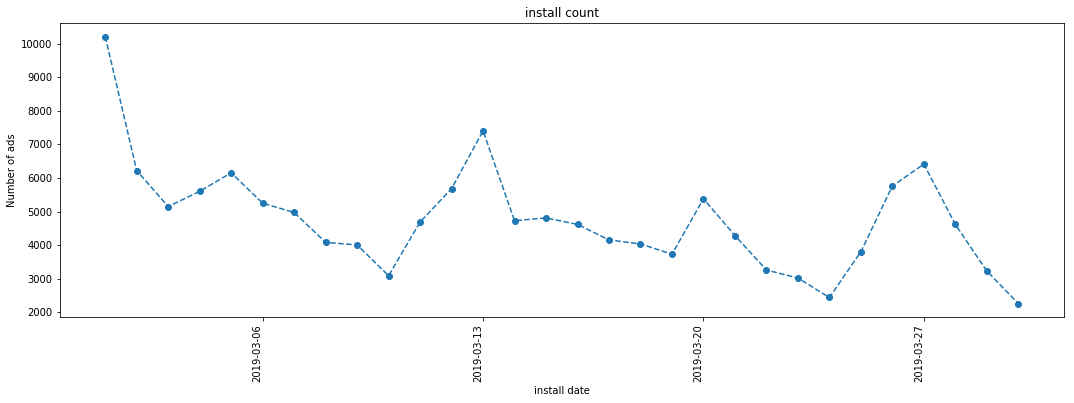

In [29]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(ai_cnt['ai_event_date'],ai_cnt['ai_cnt'],'o--')
ax.set_title('install count')
ax.set_xlabel('install date')
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Number of ads')

In [30]:
ai_uid_isnull = ai[ai['uid'].isnull()]
ai_uid_notnull = ai[ai['uid'].notnull()]

In [31]:
ai_uid_isnull.describe()

,article_id,ai_dow,ai_hour
count,0.0,80934.000000,80934.000000
mean,NaN,2.999283,12.187746
std,NaN,1.932088,7.504729
min,NaN,0.000000,0.000000
25%,NaN,1.000000,4.000000
50%,NaN,3.000000,14.000000
75%,NaN,5.000000,18.000000
max,NaN,6.000000,23.000000


In [32]:
ai_uid_notnull.describe()

,article_id,ai_dow,ai_hour
count,62212.000000,62212.000000,62212.000000
mean,4156.216807,2.822253,11.735003
std,791.619978,1.832151,7.799330
min,3047.000000,0.000000,0.000000
25%,3405.000000,1.000000,3.000000
50%,4130.000000,3.000000,13.000000
75%,4834.000000,4.000000,19.000000
max,5596.000000,6.000000,23.000000


In [33]:
ai_uid_notnull['article_id'] = ai_uid_notnull['article_id'].astype(int)

/Users/dwightliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
ai_uid_notnull['article_id'].value_counts()

3172    10606
3505     3293
5335     2806
4656     1904
5077     1788
4433     1458
4763     1179
3320     1171
4382     1163
4150     1151
3733     1003
4318      965
5237      947
3814      887
4781      815
5351      762
3952      738
3443      718
4151      712
3348      535
4451      513
3601      512
5060      495
4463      495
5568      472
5031      461
3830      415
3982      388
3569      356
3327      336
        ...  
3054        1
5197        1
5229        1
3182        1
5261        1
3214        1
5293        1
5325        1
4717        1
4653        1
4621        1
4589        1
4799        1
3471        1
3503        1
3535        1
3663        1
3791        1
3855        1
3919        1
3951        1
4047        1
4079        1
4141        1
4173        1
4301        1
4397        1
4429        1
4557        1
4146        1
Name: article_id, Length: 2550, dtype: int64

In [35]:
article_top_ten_list = ai_uid_notnull['article_id'].value_counts().nlargest(10).index.tolist()
ai_uid_notnull['article_id_std'] = np.where(ai_uid_notnull['article_id'].isin(article_top_ten_list),ai_uid_notnull['article_id'],'non_top_ten')

/Users/dwightliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


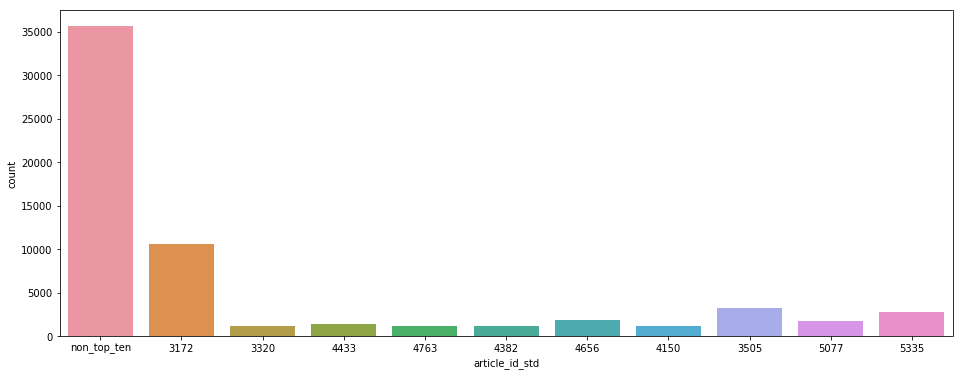

In [36]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="article_id_std", data=ai_uid_notnull)

In [37]:
### checkout

In [38]:
ck.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17334 entries, 0 to 17333
Data columns (total 4 columns):
device_id          17186 non-null object
checkout_time      17334 non-null int64
checkout_status    17334 non-null object
trial_converted    16303 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 541.8+ KB


In [39]:
ck = ck.drop_duplicates()

In [40]:
ck['checkout_time'] = pd.to_datetime(ck['checkout_time'],unit='s')

In [41]:
ck.head()

,device_id,checkout_time,checkout_status,trial_converted
0,be6-8d92a4-15483,2019-03-09 14:56:59,trial_started,1.0
1,be6-8d92a4-0a029,2019-03-13 13:33:58,trial_started,1.0
2,be6-8d92a4-0a851,2019-03-14 18:58:01,trial_started,1.0
3,be6-8d92a4-13f97,2019-03-29 04:56:48,trial_started,1.0
4,be6-8d92a4-1269e,2019-03-07 17:38:20,trial_started,1.0


In [42]:
ck.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17333 entries, 0 to 17333
Data columns (total 4 columns):
device_id          17186 non-null object
checkout_time      17333 non-null datetime64[ns]
checkout_status    17333 non-null object
trial_converted    16302 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 677.1+ KB


# What can you tell us about the effectiveness of our ad campaigns in terms of generating paid subscriptions?

In [43]:
uid_bc_lst = list(bc['uid'].unique())

In [44]:
did_ai_lst = list(ai.loc[ai['uid'].isin(uid_bc_lst),'device_id'].unique())

In [45]:
ck_ad = ck[ck['device_id'].isin(did_ai_lst)]
ck_ad['acquired'] = np.where( (ck_ad['checkout_status'] == 'direct_purchase'), 1, 
         np.where( (ck_ad['checkout_status'] == 'trial_started') & (ck_ad['trial_converted'] == 1), 1, 0) 
        )

/Users/dwightliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
print('total adtertisement we show in Facebook: ',bc.shape[0])
print('total customers we acquired: ',ck_ad['acquired'].sum())
print('conversion rate: {}%'.format(round(100*ck_ad['acquired'].sum()/bc.shape[0],4)))

total adtertisement we show in Facebook:  2023418
total customers we acquired:  1008
conversion rate: 0.0498%


# What is our general time to acquisition from seeing the ad to getting a paid subscriber? (Assume trial conversion always takes exactly 7 days)

In [47]:
ck_acq = ck_ad[ck_ad['acquired'] == 1].copy()

In [48]:
ck_acq['acquired_type'] = np.where((ck_acq['checkout_status'] == 'direct_purchase'), 'direct', 'through_trial')

In [49]:
ck_acq = ck_acq[['device_id','checkout_time','acquired_type']].copy()

In [50]:
ai_need = ai[['uid','device_id']].drop_duplicates().copy()

In [51]:
bc.columns

Index(['platform', 'campaign_name', 'ad_event_time', 'uid', 'ad_event_date',
       'ad_dow', 'ad_hour', 'campaign_name_std'],
      dtype='object')

In [52]:
bc_need = bc[['uid','ad_event_time']].drop_duplicates().sort_values(by='ad_event_time').drop_duplicates(subset='uid', keep='first')

In [53]:
m1 = pd.merge(ck_acq, ai_need, on='device_id', how='inner')

In [54]:
m2 = pd.merge(m1, bc_need, on='uid', how='inner')

In [55]:
m2.columns

Index(['device_id', 'checkout_time', 'acquired_type', 'uid', 'ad_event_time'], dtype='object')

In [56]:
m2.head()

,device_id,checkout_time,acquired_type,uid,ad_event_time
0,be6-8d92a4-0a029,2019-03-13 13:33:58,through_trial,116184,2019-03-13 13:32:20
1,be6-8d92a4-0a851,2019-03-14 18:58:01,through_trial,18cd91,2019-03-14 18:55:14
2,be6-8d92a4-1291f,2019-03-15 03:38:39,through_trial,04c9b0,2019-03-03 02:37:19
3,be6-8d92a4-03420,2019-03-16 14:36:56,through_trial,12ec30,2019-03-16 14:33:54
4,be6-8d92a4-10f02,2019-03-05 00:20:16,through_trial,183c2e,2019-03-05 00:17:22


In [57]:
#m2['checkout_time'] = pd.to_datetime(m2['checkout_time'])
#m2['ad_event_time'] = pd.to_datetime(m2['ad_event_time'])
m2['day_to_acq'] = m2['checkout_time']-m2['ad_event_time']
m2['day_to_acq'] = m2['day_to_acq'].dt.days

In [58]:
m2

,device_id,checkout_time,acquired_type,uid,ad_event_time,day_to_acq
0,be6-8d92a4-0a029,2019-03-13 13:33:58,through_trial,116184,2019-03-13 13:32:20,0
1,be6-8d92a4-0a851,2019-03-14 18:58:01,through_trial,18cd91,2019-03-14 18:55:14,0
2,be6-8d92a4-1291f,2019-03-15 03:38:39,through_trial,04c9b0,2019-03-03 02:37:19,12
3,be6-8d92a4-03420,2019-03-16 14:36:56,through_trial,12ec30,2019-03-16 14:33:54,0
4,be6-8d92a4-10f02,2019-03-05 00:20:16,through_trial,183c2e,2019-03-05 00:17:22,0
5,be6-8d92a4-05434,2019-03-12 22:38:13,through_trial,17b239,2019-03-12 22:33:24,0
6,be6-8d92a4-0b11b,2019-03-01 20:15:05,through_trial,141f10,2019-03-01 20:12:58,0
7,be6-8d92a4-026c4,2019-03-04 02:58:58,through_trial,0eac1b,2019-03-01 06:37:03,2
8,be6-8d92a4-15f28,2019-03-26 05:20:21,through_trial,13dc9f,2019-03-26 05:17:55,0
9,be6-8d92a4-14edc,2019-03-12 23:54:47,through_trial,01ac30,2019-03-12 23:06:29,0


In [59]:
m2['day_to_acq'] = np.where(m2['acquired_type'] == 'through_trial', m2['day_to_acq'] + 7, m2['day_to_acq'])

In [60]:
m2['day_to_acq'].mean()

8.490079365079366

In [61]:
m2[m2['day_to_acq'] < 0]

,device_id,checkout_time,acquired_type,uid,ad_event_time,day_to_acq


In [62]:
cnt_map = bc.groupby('uid')['ad_event_time'].size()
bc['contact_times'] = bc['uid'].map(cnt_map)

In [63]:
bc['contact_times'].max()

49

In [64]:
check = bc[bc['contact_times'] == 49]

In [65]:
contacts = bc[['uid','contact_times']].drop_duplicates()

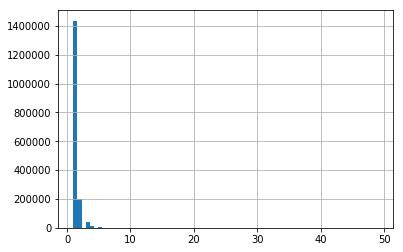

In [66]:
contacts['contact_times'].hist(bins=75)

### modeling prep

In [67]:
bc.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023418 entries, 0 to 2024076
Data columns (total 9 columns):
platform             2023418 non-null object
campaign_name        2023418 non-null object
ad_event_time        2023418 non-null datetime64[ns]
uid                  2023418 non-null object
ad_event_date        2023418 non-null object
ad_dow               2023418 non-null int64
ad_hour              2023418 non-null int64
campaign_name_std    2023418 non-null object
contact_times        2023418 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 154.4+ MB


In [68]:
minima = bc.groupby('uid')['ad_event_time'].min()
bc['min_event'] = bc['uid'].map(minima)

In [69]:
bc_need = bc[bc['min_event'] == bc['ad_event_time']].copy()

In [70]:
bc_need

,platform,campaign_name,ad_event_time,uid,ad_event_date,ad_dow,ad_hour,campaign_name_std,contact_times,min_event
0,iPhone,author_88,2019-03-01 00:00:00,15a862,2019-03-01,4,0,author_88,1,2019-03-01 00:00:00
1,iPhone,author_219,2019-03-01 00:00:01,0a9627,2019-03-01,4,0,non_top_ten,1,2019-03-01 00:00:01
2,iPhone,author_88,2019-03-01 00:00:02,073ae4,2019-03-01,4,0,author_88,1,2019-03-01 00:00:02
3,iPhone,author_88,2019-03-01 00:00:04,12aff3,2019-03-01,4,0,author_88,2,2019-03-01 00:00:04
4,iPhone,author_88,2019-03-01 00:00:04,1a0528,2019-03-01,4,0,author_88,1,2019-03-01 00:00:04
5,iPhone,author_88,2019-03-01 00:00:04,12d742,2019-03-01,4,0,author_88,1,2019-03-01 00:00:04
6,iPhone,author_187,2019-03-01 00:00:06,02346f,2019-03-01,4,0,non_top_ten,2,2019-03-01 00:00:06
7,iPhone,author_88,2019-03-01 00:00:10,1524f9,2019-03-01,4,0,author_88,2,2019-03-01 00:00:10
8,iPhone,author_22,2019-03-01 00:00:10,191fcd,2019-03-01,4,0,non_top_ten,1,2019-03-01 00:00:10
9,iPhone,author_88,2019-03-01 00:00:14,0ac750,2019-03-01,4,0,author_88,3,2019-03-01 00:00:14


In [71]:
need_cols = ['uid','ad_dow','ad_hour','contact_times','campaign_name_std','platform']

In [72]:
part1 = bc_need[need_cols].copy()

In [73]:
### part2

In [74]:
ai_uid_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62212 entries, 1 to 143109
Data columns (total 9 columns):
uid               62212 non-null object
device_id         62212 non-null object
ai_event_time     62212 non-null datetime64[ns]
article_id        62212 non-null int64
source            62212 non-null object
ai_event_date     62212 non-null object
ai_dow            62212 non-null int64
ai_hour           62212 non-null int64
article_id_std    62212 non-null object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 7.2+ MB


In [75]:
ai_uid_notnull['uid'].nunique()

61805

In [76]:
ai_uid_notnull[['uid','device_id']].drop_duplicates().shape

(62181, 2)

In [77]:
ai_need = ai_uid_notnull.sort_values(by='ai_event_time').drop_duplicates(subset=['uid','device_id'], keep='first')

In [78]:
need_cols = ['uid','device_id','source','ai_dow','ai_hour','article_id_std']

In [79]:
part2 = ai_need[need_cols].copy()

In [80]:
### part3

In [81]:
part1

,uid,ad_dow,ad_hour,contact_times,campaign_name_std,platform
0,15a862,4,0,1,author_88,iPhone
1,0a9627,4,0,1,non_top_ten,iPhone
2,073ae4,4,0,1,author_88,iPhone
3,12aff3,4,0,2,author_88,iPhone
4,1a0528,4,0,1,author_88,iPhone
5,12d742,4,0,1,author_88,iPhone
6,02346f,4,0,2,non_top_ten,iPhone
7,1524f9,4,0,2,author_88,iPhone
8,191fcd,4,0,1,non_top_ten,iPhone
9,0ac750,4,0,3,author_88,iPhone


In [82]:
part2

,uid,device_id,source,ai_dow,ai_hour,article_id_std
852,0248b3,be6-8d92a4-0f239,facebook_ads,4,0,3172
853,15dcf1,be6-8d92a4-0fc5f,facebook_ads,4,0,non_top_ten
854,0fe17f,be6-8d92a4-0034e,facebook_ads,4,0,3172
10861,114b04,be6-8d92a4-13ba5,facebook_ads,4,0,3172
4377,0517ea,be6-8d92a4-231e1,facebook_ads,4,0,3172
173,0fb447,be6-8d92a4-1f7fb,organic,4,0,non_top_ten
7691,042e6d,be6-8d92a4-0c854,organic,4,0,3172
2136,03b9b9,be6-8d92a4-1e3b3,facebook_ads,4,0,3172
4378,0f5ff3,be6-8d92a4-1c10c,facebook_ads,4,0,3172
3169,0a809a,be6-8d92a4-00376,organic,4,0,3172


In [83]:
converted_device_id_lst = list(ck_acq['device_id'].unique())

In [84]:
part2['converted'] = np.where(part2['device_id'].isin(converted_device_id_lst),1,0)

In [85]:
t = pd.merge(part1,part2,on='uid',how='left')

In [86]:
t['app_converted'] = np.where(t['device_id'].isnull(),0,1)

In [99]:
t['converted'] = t['converted'].fillna(0)
t['converted'] = t['converted'].astype(int)

In [88]:
t['converted'].mean()

0.0005949884935376324

In [89]:
t['app_converted'].mean()

0.025479228928033008

In [100]:
t

,uid,ad_dow,ad_hour,contact_times,campaign_name_std,platform,device_id,source,ai_dow,ai_hour,article_id_std,converted,app_converted
0,15a862,4,0,1,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0,0
1,0a9627,4,0,1,non_top_ten,iPhone,NaN,NaN,NaN,NaN,NaN,0,0
2,073ae4,4,0,1,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0,0
3,12aff3,4,0,2,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0,0
4,1a0528,4,0,1,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0,0
5,12d742,4,0,1,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0,0
6,02346f,4,0,2,non_top_ten,iPhone,NaN,NaN,NaN,NaN,NaN,0,0
7,1524f9,4,0,2,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0,0
8,191fcd,4,0,1,non_top_ten,iPhone,NaN,NaN,NaN,NaN,NaN,0,0
9,0ac750,4,0,3,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0,0


In [101]:
t.to_csv('data/data_clean_full.csv',index=False)

In [91]:
### first model 

In [92]:
data = t[['ad_dow','ad_hour','contact_times','campaign_name_std','platform','app_converted','converted']]

In [93]:
data['converted'].mean()

0.0005949884935376324

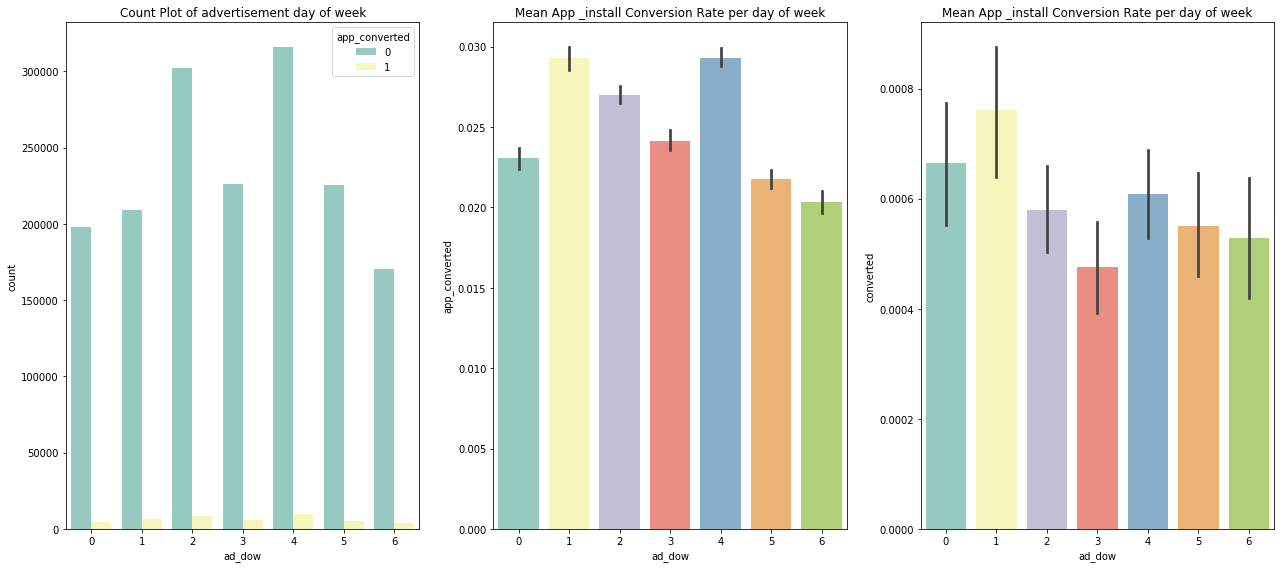

In [94]:
# Visualization of different countries
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='ad_dow', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='ad_dow', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='ad_dow', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

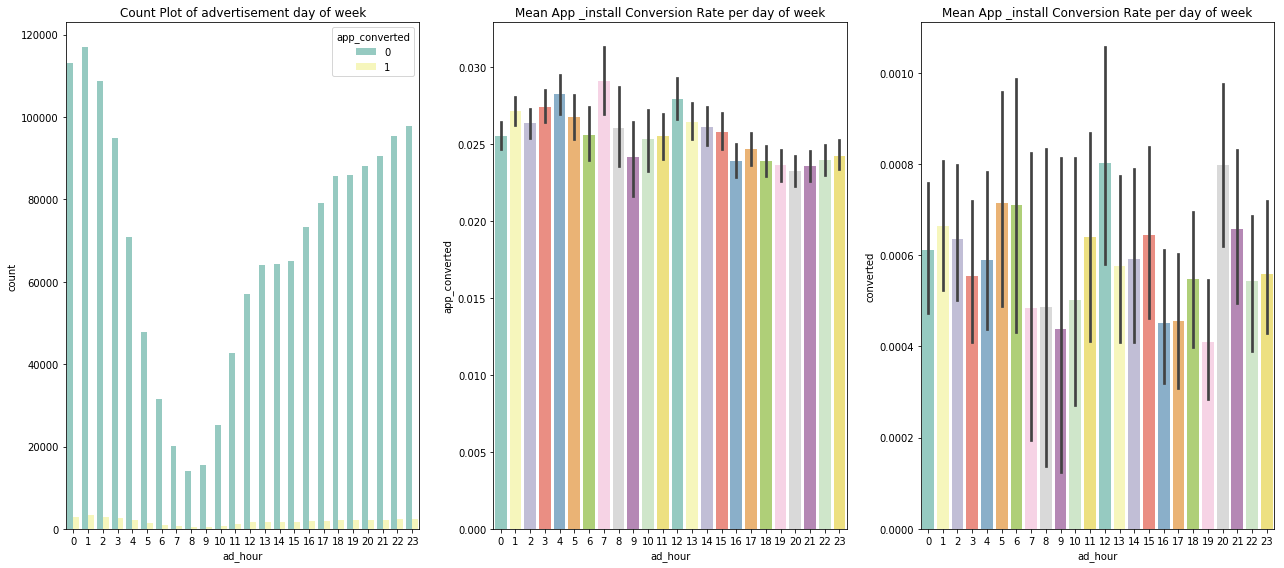

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='ad_hour', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='ad_hour', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='ad_hour', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

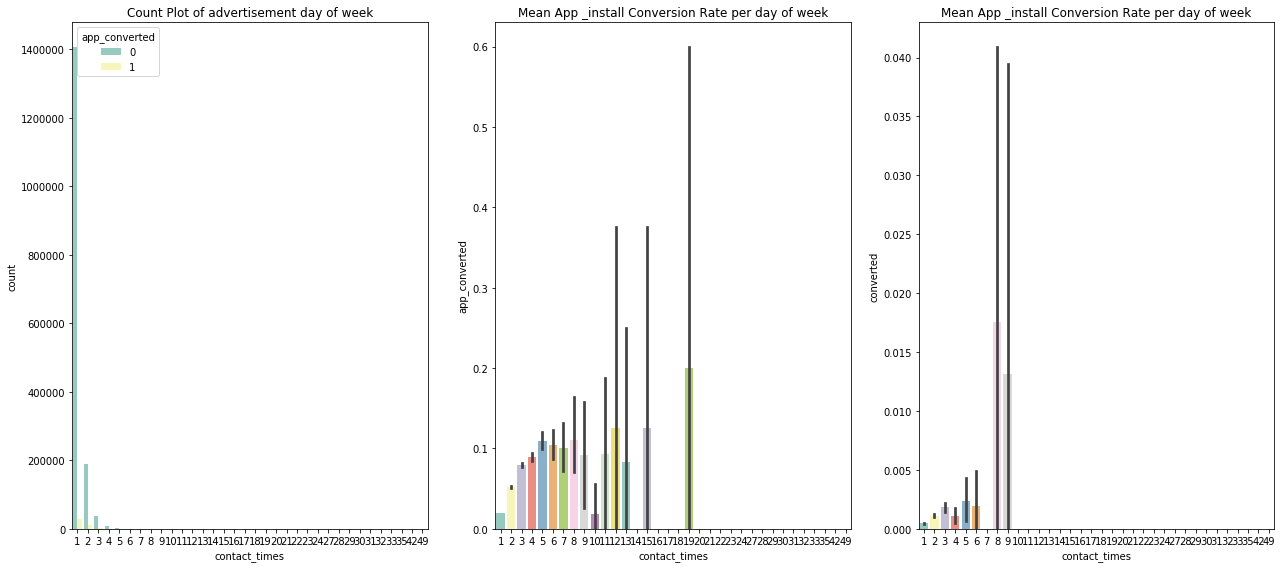

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='contact_times', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='contact_times', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='contact_times', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

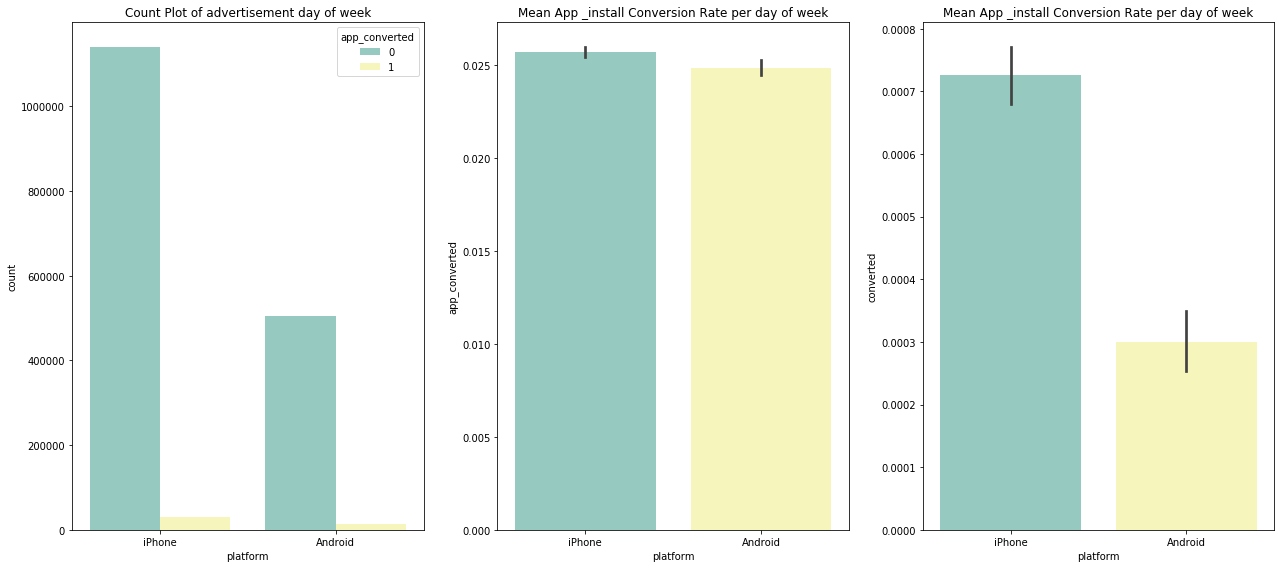

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='platform', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='platform', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='platform', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

# Propensity Modeling from ad to app install

In [121]:
data = pd.read_csv('data/data_clean_full.csv')

In [106]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690789 entries, 0 to 1690788
Data columns (total 13 columns):
uid                  1690789 non-null object
ad_dow               1690789 non-null int64
ad_hour              1690789 non-null int64
contact_times        1690789 non-null int64
campaign_name_std    1690789 non-null object
platform             1690789 non-null object
device_id            43080 non-null object
source               43080 non-null object
ai_dow               43080 non-null float64
ai_hour              43080 non-null float64
article_id_std       43080 non-null object
converted            1690789 non-null int64
app_converted        1690789 non-null int64
dtypes: float64(2), int64(5), object(6)
memory usage: 167.7+ MB


In [104]:
data.columns

Index(['uid', 'ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std',
       'platform', 'device_id', 'source', 'ai_dow', 'ai_hour',
       'article_id_std', 'converted', 'app_converted'],
      dtype='object')

In [107]:
features = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std','platform']
target = ['app_converted']

In [108]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_192"; Java(TM) SE Runtime Environment (build 1.8.0_192-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.192-b12, mixed mode)
  Starting server from /Users/dwightliu/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/v2/d_crr6712h1_4jpbv0dbvsnc0000gn/T/tmp856p1v9q
  JVM stdout: /var/folders/v2/d_crr6712h1_4jpbv0dbvsnc0000gn/T/tmp856p1v9q/h2o_dwightliu_started_from_python.out
  JVM stderr: /var/folders/v2/d_crr6712h1_4jpbv0dbvsnc0000gn/T/tmp856p1v9q/h2o_dwightliu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,"1 year, 2 months and 6 days !!!"
H2O cluster name:,H2O_from_python_dwightliu_fzqpxt
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [109]:
df = data[features+target].copy()

In [110]:
h2o_df = H2OFrame(df)
h2o_df.summary()

/Users/dwightliu/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


,ad_dow,ad_hour,contact_times,campaign_name_std,platform,app_converted
type,int,int,int,enum,enum,int
mins,0.0,0.0,1.0,,,0.0
mean,2.9752127557016212,11.850216673990676,1.197006249744937,,,0.025479228928033008
maxs,6.0,23.0,49.0,,,1.0
sigma,1.8539350044923615,7.932310187374041,0.5578237544668238,,,0.15757554539568802
zeros,202885,116070,0,,,1647709
missing,0,0,0,0,0,0
0,4.0,0.0,1.0,author_88,iPhone,0.0
1,4.0,0.0,1.0,non_top_ten,iPhone,0.0
2,4.0,0.0,1.0,author_88,iPhone,0.0


In [112]:
# Split into 80% training and 20% test dataset
h2o_df['app_converted'] = h2o_df['app_converted'].asfactor()
strat_split = h2o_df['app_converted'].stratified_split(test_frac=0.2, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

#feature = ['city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model',
          #'vehicle_year','day_of_week','is_weekend','is_bgc','vehicle_age']
feature = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std','platform']
target = 'app_converted'

In [113]:
# Build random forest model
rf = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                seed=1, score_each_iteration=True)
rf.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


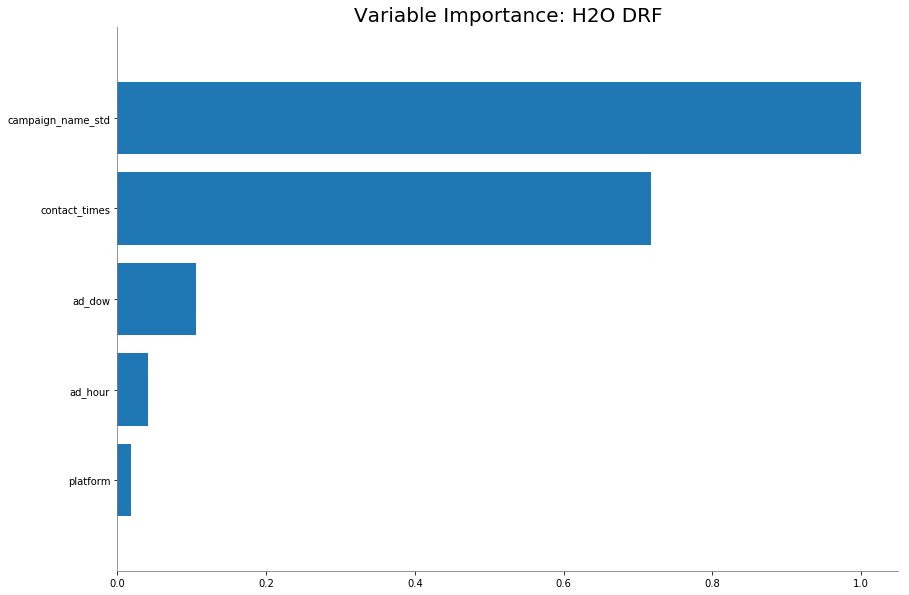

In [114]:
rf.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


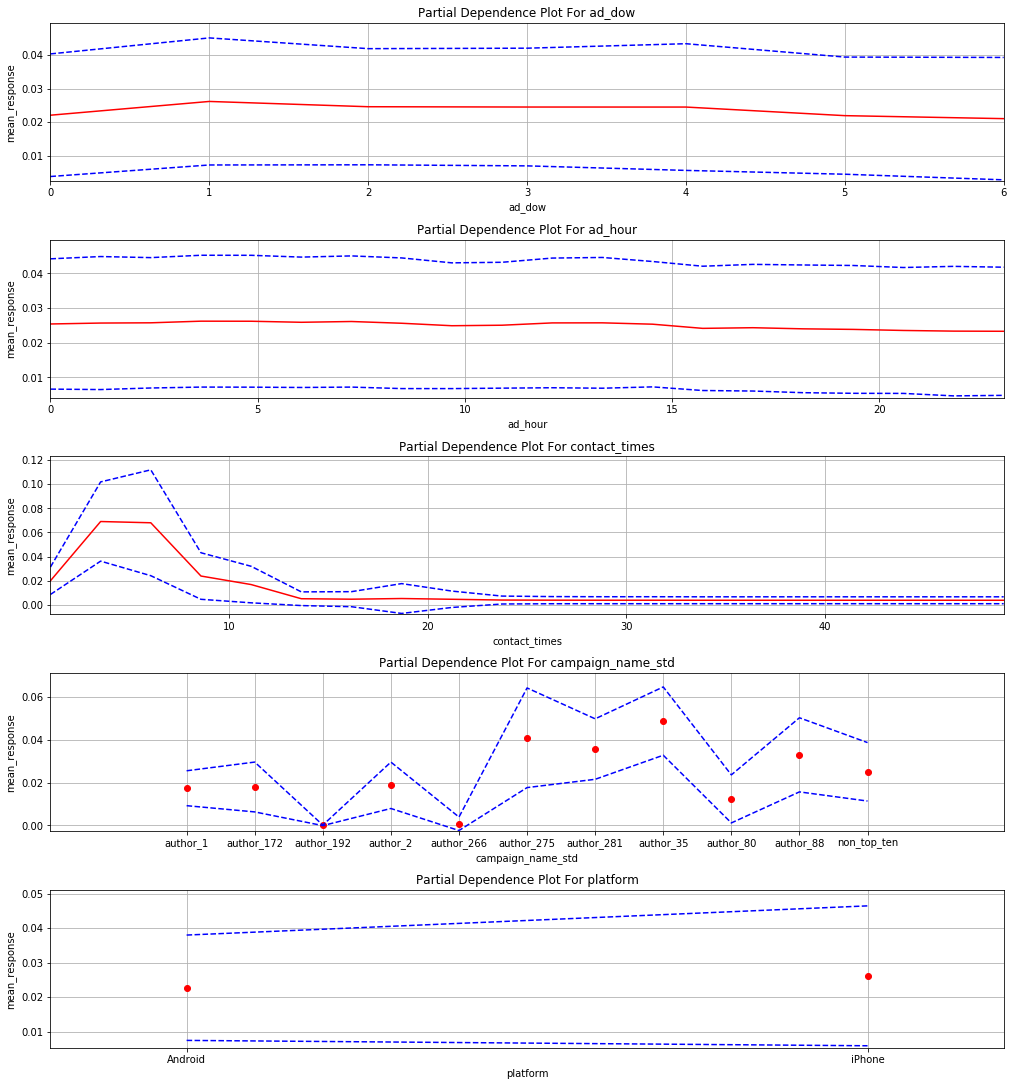

In [116]:
_ = rf.partial_plot(train, cols=feature, figsize=(14, 15))

In [ ]:
## from paid ad to app install, we can see that based on the feature importance, 
### 1.campaign_name is the most influential feature: with the partial dependence plot, we know that author 35,author 275 has higher chance to convert, we can suggest marketing team to promote these two authors,
### however like author 192 and 266, I'd suggest team to dig into two direction, fully understand the taste of audience we recommend to, and suggest the author that how the customer respond to the content.
### 2. contact times: We can see taht < 7 times, the propensity of audience will increase with contact times, however > 7, the propensity decrease, therefore,
### I'd suggest the marketing, don't contact the audience more than 7 times in one month. And it also save some budget. Or we can consider another strgety like providing promo code to the customers we already contact for 7 times.
### 3.advertisement day of week:

# Propensity Modeling from ad to paid subscribe

In [122]:
need_cols = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std',
    'platform', 'source', 'ai_dow', 'ai_hour',
    'article_id_std', 'converted', 'app_converted']
data = data[need_cols].copy()
data = data[data['app_converted'] == 1].copy()

In [123]:
data = data.drop(['app_converted','device_id'],axis=1)

In [124]:
data.head()

,ad_dow,ad_hour,contact_times,campaign_name_std,platform,source,ai_dow,ai_hour,article_id_std,converted
12,4,0,1,author_88,iPhone,facebook_ads,4.0,0.0,3172,0
18,4,0,1,author_88,iPhone,facebook_ads,4.0,0.0,3172,0
36,4,0,4,author_88,iPhone,facebook_ads,4.0,0.0,3172,0
37,4,0,4,author_88,iPhone,facebook_ads,4.0,0.0,3172,0
87,4,0,2,author_88,Android,facebook_ads,4.0,0.0,3172,0


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43080 entries, 12 to 1690786
Data columns (total 10 columns):
ad_dow               43080 non-null int64
ad_hour              43080 non-null int64
contact_times        43080 non-null int64
campaign_name_std    43080 non-null object
platform             43080 non-null object
source               43080 non-null object
ai_dow               43080 non-null float64
ai_hour              43080 non-null float64
article_id_std       43080 non-null object
converted            43080 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 3.6+ MB


In [126]:
features = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std',
    'platform', 'source', 'ai_dow', 'ai_hour',
    'article_id_std']
target = ['converted']

In [127]:
df = data[features+target].copy()

In [128]:
h2o_df = H2OFrame(df)
h2o_df.summary()

/Users/dwightliu/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


,ad_dow,ad_hour,contact_times,campaign_name_std,platform,source,ai_dow,ai_hour,article_id_std,converted
type,int,int,int,enum,enum,enum,int,int,enum,int
mins,0.0,0.0,1.0,,,,0.0,0.0,,0.0
mean,2.887465181058502,11.478899721448487,1.5081244196843127,,,,2.828946146703836,11.602506963788278,,0.023351903435468894
maxs,6.0,23.0,19.0,,,,6.0,23.0,,1.0
sigma,1.7812575502860493,7.91334427796891,0.8628285431367911,,,,1.7553710221241028,7.887591690597997,,0.15102026835702542
zeros,4676,2968,0,,,,4486,2795,,42074
missing,0,0,0,0,0,0,0,0,0,0
0,4.0,0.0,1.0,author_88,iPhone,facebook_ads,4.0,0.0,3172,0.0
1,4.0,0.0,1.0,author_88,iPhone,facebook_ads,4.0,0.0,3172,0.0
2,4.0,0.0,4.0,author_88,iPhone,facebook_ads,4.0,0.0,3172,0.0


In [129]:
# Split into 80% training and 20% test dataset
h2o_df['converted'] = h2o_df['converted'].asfactor()
strat_split = h2o_df['converted'].stratified_split(test_frac=0.2, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

#feature = ['city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model',
          #'vehicle_year','day_of_week','is_weekend','is_bgc','vehicle_age']
feature = features = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std',
    'platform', 'source', 'ai_dow', 'ai_hour',
    'article_id_std']
target = 'converted'

In [130]:
# Build random forest model
rf = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                seed=1, score_each_iteration=True)
rf.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


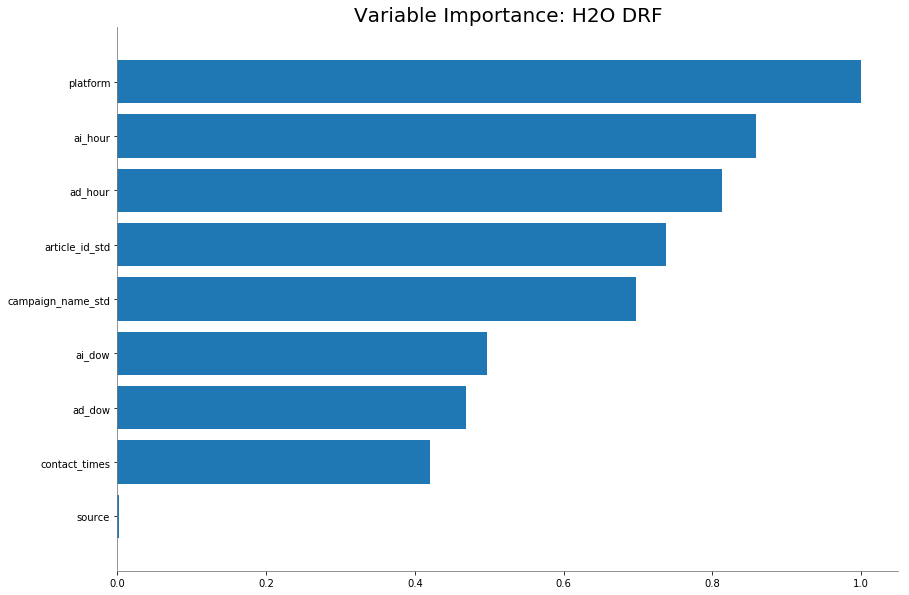

In [131]:
rf.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


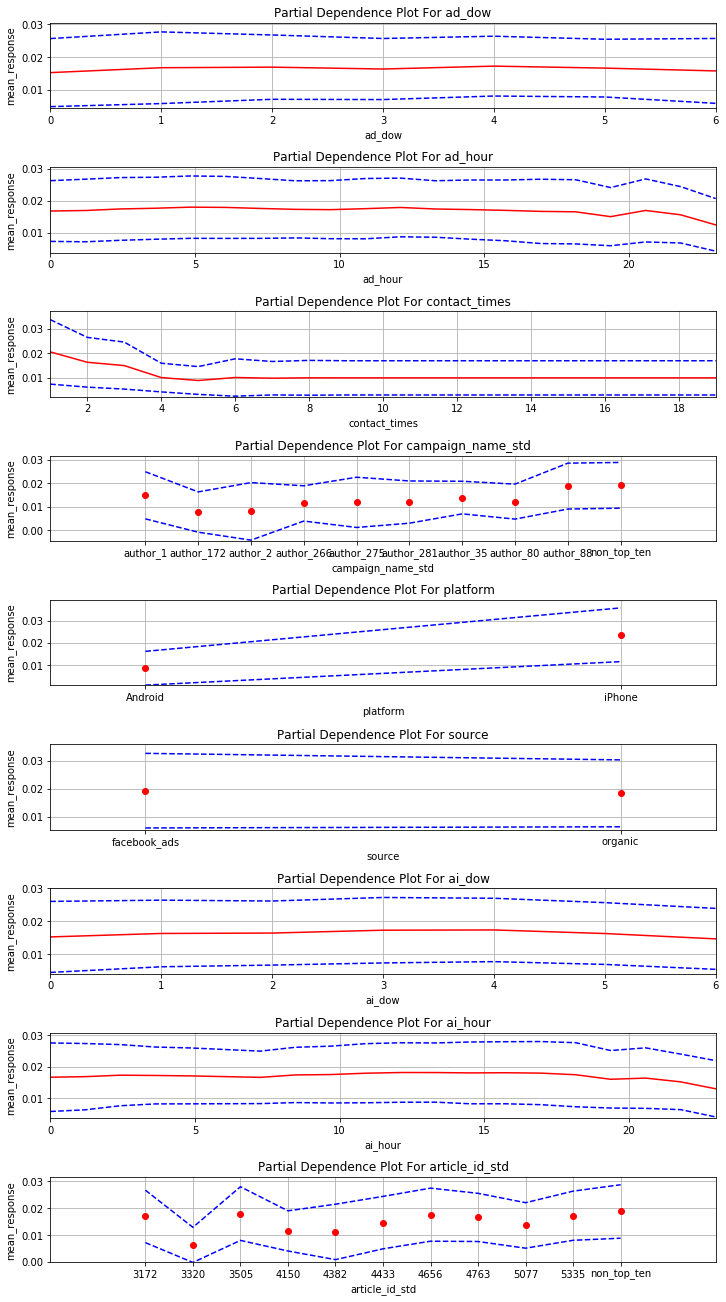

In [135]:
_ = rf.partial_plot(train, cols=feature, figsize=(10, 18))

In [98]:
'''
#Business goal
We want to expand the spend on the sponsored content strategy while maintaining a level of efficiency. 

#The Questions

-	What can you tell us about the effectiveness of our ad campaigns in terms of generating paid subscriptions?
-	What is our general time to acquisition from seeing the ad to getting a paid subscriber? (Assume trial conversion always takes exactly 7 days)
-	What are the factors that affect the conversion rate to a paid subscription and what do you think that tells us about these visitors?

#Additional Discussion
-	What would you recommend the performance marketing manager do? What would you recommend the product manager do? 
-	What additional information would make this analysis more “complete” or actionable? If given that information and more time, how would that change your analysis?
'''

'\n#Business goal\nWe want to expand the spend on the sponsored content strategy while maintaining a level of efficiency. \n\n#The Questions\n\n-\tWhat can you tell us about the effectiveness of our ad campaigns in terms of generating paid subscriptions?\n-\tWhat is our general time to acquisition from seeing the ad to getting a paid subscriber? (Assume trial conversion always takes exactly 7 days)\n-\tWhat are the factors that affect the conversion rate to a paid subscription and what do you think that tells us about these visitors?\n\n#Additional Discussion\n-\tWhat would you recommend the performance marketing manager do? What would you recommend the product manager do? \n-\tWhat additional information would make this analysis more “complete” or actionable? If given that information and more time, how would that change your analysis?\n'